# 2. GAN

## 1. Training Stage

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
hts_df = pd.read_csv('hts_example.csv', index_col=None)
    
num_categories = {}
for column in hts_df.columns:
    num_unique = hts_df[column].nunique()
    num_categories[column] = num_unique
    print(f"Column '{column}' has {num_unique} unique categories.")

Column 'start_type' has 5 unique categories.
Column 'act_num' has 9 unique categories.
Column 'mode_num' has 9 unique categories.
Column 'end_type' has 5 unique categories.


In [3]:
def dequantize_data(data):
    data_continuous = data.copy().astype(float)
    for column in data_continuous.columns:
        data_continuous[column] += np.random.uniform(0, 1, size=data_continuous.shape[0])
    return data_continuous

data_continuous = dequantize_data(hts_df)
data_tensor = torch.tensor(data_continuous.values, dtype=torch.float32).to(device)

In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

In [5]:
z_dim = 64
hidden_dim = 512

input_dim = data_tensor.shape[1]
generator = Generator(input_dim=z_dim, output_dim=input_dim, hidden_dim=hidden_dim).to(device)
discriminator = Discriminator(input_dim=input_dim, hidden_dim=hidden_dim).to(device)

In [6]:
learning_rate = 1e-4
batch_size = 512
num_epochs = 50

criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

dataset = torch.utils.data.TensorDataset(data_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

real_label = 1.0
fake_label = 0.0

generator.train()
discriminator.train()
for epoch in range(1, num_epochs + 1):
    for batch in dataloader:
        real_data = batch[0].to(device)
        batch_size = real_data.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_data = generator(z)
        d_real = discriminator(real_data)
        d_fake = discriminator(fake_data)
        d_loss_real = criterion(d_real, torch.full((batch_size, 1), real_label, device=device))
        d_loss_fake = criterion(d_fake, torch.full((batch_size, 1), fake_label, device=device))
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_data = generator(z)
        g_loss = criterion(discriminator(fake_data), torch.full((batch_size, 1), real_label, device=device))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    if epoch % 4 == 0 or epoch == 1:
        print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

Epoch [1/50], D Loss: 0.5278, G Loss: 1.5799
Epoch [4/50], D Loss: 1.2443, G Loss: 0.7562
Epoch [8/50], D Loss: 1.5180, G Loss: 0.7586
Epoch [12/50], D Loss: 1.4443, G Loss: 0.8494
Epoch [16/50], D Loss: 1.3150, G Loss: 0.7701
Epoch [20/50], D Loss: 1.2143, G Loss: 0.8620
Epoch [24/50], D Loss: 1.2677, G Loss: 0.8416
Epoch [28/50], D Loss: 1.3466, G Loss: 0.7192
Epoch [32/50], D Loss: 1.3121, G Loss: 0.8410
Epoch [36/50], D Loss: 1.3423, G Loss: 0.7493
Epoch [40/50], D Loss: 1.2244, G Loss: 0.7625
Epoch [44/50], D Loss: 1.3864, G Loss: 0.7133
Epoch [48/50], D Loss: 1.3667, G Loss: 0.7086


## 2. Testing Stage

In [7]:
columns = ['start_type', 'act_num', 'mode_num', 'end_type']
num_samples=3000

generator.eval()

with torch.no_grad():
    z = torch.randn(num_samples, z_dim).to(device)
    samples = generator(z).cpu().numpy()

generated_categories = pd.DataFrame(samples, columns=columns)
for column in columns:
    max_cat = num_categories[column] - 1
    generated_categories[column] = np.floor(generated_categories[column]).astype(int)
    generated_categories[column] = np.clip(generated_categories[column], 0, max_cat)

<ipython-input-12-9bbf882c1d80>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=15)


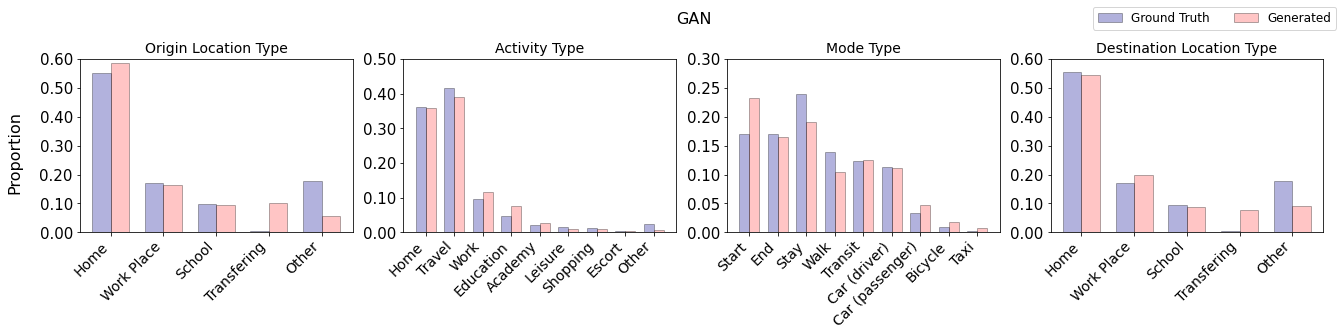

In [12]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']

fig, axs = plt.subplots(1, 4, figsize=(18, 3))

formatter = FormatStrFormatter('%.2f')

fig.tight_layout(h_pad=1, w_pad=2)

ylim_list = [0.60, 0.5, 0.3, 0.6]
sub_title_list = ['Origin Location Type', 'Activity Type', 'Mode Type', 'Destination Location Type']
bar_width = 0.35
offset = bar_width / 2

xtick_labels_list = [
    ['Home', 'Work Place', 'School', 'Transfering', 'Other'],  # Start Location Type
    ['Home', 'Travel', 'Work', 'Education', 'Academy', 'Leisure', 'Shopping', 'Escort', 'Other'],  # Activity Type
    ['Start', 'End', 'Stay', 'Walk', 'Transit', 'Car (driver)', 'Car (passenger)', 'Bicycle', 'Taxi'],  # Mode Type
    ['Home', 'Work Place', 'School', 'Transfering', 'Other']  # End Location Type
]

for column, ylim, sub_title, xtick_labels, ax in zip(columns, ylim_list, sub_title_list, xtick_labels_list, axs.flatten()):
    
    # Ground truth
    unique_hts, counts_hts = np.unique(hts_df[column], return_counts=True)
    ax.set_ylim([0, ylim])
    positions_hts = np.arange(len(unique_hts))
    ax.bar(positions_hts - offset, counts_hts / counts_hts.sum(), 
           width=bar_width, color='#00008F', edgecolor='black', alpha=0.3, label='Ground Truth')
    
    # Generated data
    unique_gen, counts_gen = np.unique(generated_categories[column], return_counts=True)
    positions_gen = np.arange(len(unique_gen))
    ax.bar(positions_gen + offset, counts_gen / counts_gen.sum(), 
           width=bar_width, color='#FF4040', edgecolor='black', alpha=0.3, label='Generated')
    
    ax.set_xticks([int(x) for x in unique_hts])
    ax.set_xticklabels(xtick_labels, fontsize=14, rotation=45, ha='right')
    
    ax.yaxis.set_major_formatter(formatter)
    ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=15)

    ax.set_title(sub_title, fontsize=14)

fig.suptitle('GAN', fontsize=16, y=1.15)
fig.text(-0.03, 0.5, 'Proportion', va='center', rotation='vertical', fontsize=16)

fig.legend(['Ground Truth', 'Generated'], loc='upper right', ncol=2, fontsize=12, 
           bbox_to_anchor=(1, 1.2), bbox_transform=fig.transFigure)

plt.savefig(f'gan_discrete.png', bbox_inches='tight', dpi=400)
plt.show()
plt.close()